# Watch out for unexpected movie recommendations !

# Introduction

Our primary goal is to enhance content-based recommendations by uncovering hidden topics within movie plots using Latent Dirichlet Allocation (LDA). By identifying these latent themes, we can move beyond conventional genre-based recommendations to suggest movies with deeper, thematic similarities.

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Analysis</p>
    <div style="padding: 0 0 2px 10px;">
    
**What will be covered :**
- **Part 1 :** Data Pre-processing (covered in data_preprocessing.ipynb)
- **Part 2 :** Data exploration
- **Part 3 :** Latent Dirichlet Allocation (LDA)
- **Part 4 :** Are topics linked to genres/labels?
- **Part 5 :** Recommendation!!!
- **Part 6 :** Do topics capture enough similarity?
- **Part 7 :** Additional features Analysis

</div></div>
<br/>

---

### Import libraries

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pickle
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from collections import Counter
from src.utils.helpers import *
from imdb import IMDb
import re
from gensim.models import LdaModel

# Worcloud
from ipywidgets import interact, widgets

# Linear Regression 
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

# PCA
from sklearn.decomposition import PCA

# Part 1: Data Prepocessing
The preprocessing step consists in cleaning and merging datasets to get data that is both devoid of problematic NaN values and grouped. 

*Comment: The code for Part 1 can be found in Notebooks/data_preprocessing.ipynb*

In [9]:
%%capture 
# %%capture: prevents all outputs from the secondary notebook from being displayed

%run "Notebooks/data_preprocessing.ipynb"
# %run: runs another notebook entirely in the current notebook

# Part 2: Data Exploration

With the preprocessing done, we remain with 2 clean dataframes:
| Dataframe        | Description                                                                      | Number of movies |
|------------------|----------------------------------------------------------------------------------|------------------|
| LDA_df           | contains only movies (rows) with no NaN values in the movie genres column        | 14604            |
| features_df      | contains only movies (rows) with no NaN values in any column                     | 5904             |



Let's now explore some of their characteristics

### Part 2.1 Movies' summaries exploration

In [10]:
# Load LDA_df
LDA_df = pd.read_csv('Data/LDA_df.csv') #Import our dataframe

# Lengths of each plot synopsis
summary_lengths = LDA_df['plot_synopsis'].apply(len)

# Stats of plot synopsis length
LDA_df['plot_synopsis'].apply(lambda x: len(x)).describe().round()

count    14604.0
mean      5427.0
std       5028.0
min        656.0
25%       2616.0
50%       4000.0
75%       6169.0
max      63959.0
Name: plot_synopsis, dtype: float64

Comment
There is a difference between the mean and the median. Let's have a look at the distribution

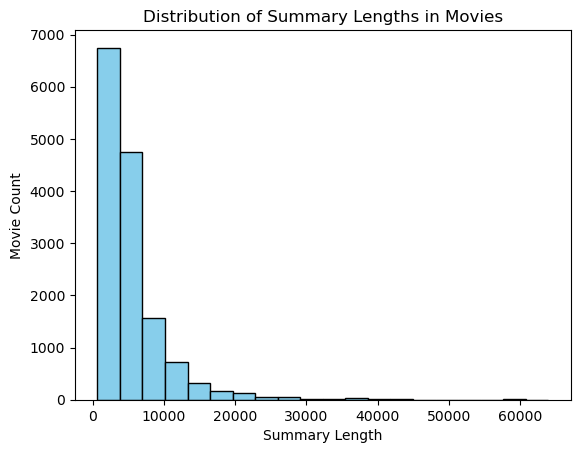

In [11]:
# Plot the histogram
plt.hist(summary_lengths, bins=20, color='skyblue', edgecolor='black')
plt.ylabel('Movie Count')  # y-axis will be the count of movies
plt.xlabel('Summary Length')  # x-axis will be the length of the summaries
plt.title('Distribution of Summary Lengths in Movies')
plt.show()

They are large differences in the summaries length. Since the distribution is a right-skewed distribution, as most summaries are short but a few are much longer.

### Part 2.2: Movies' genres exploration

Number of unique genres: 333


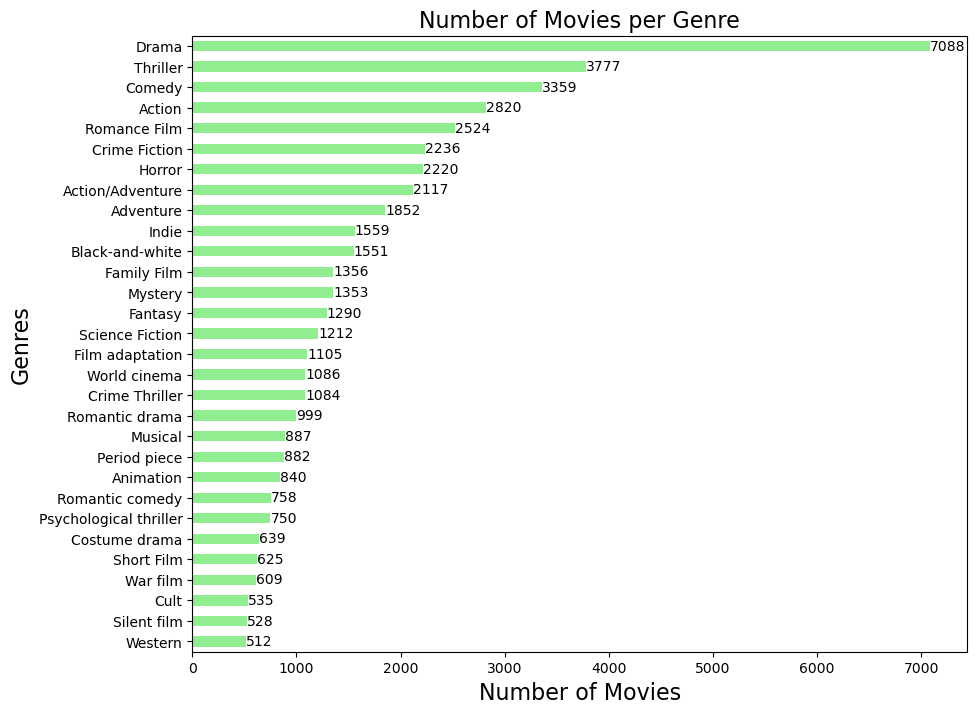

In [12]:
all_genres = LDA_df['Movie genres'].apply(ast.literal_eval).explode() # Changes elements from a list to a row

num_unique_genre = all_genres.nunique() # Creates list which each type of genre in all_genres
print("Number of unique genres:", num_unique_genre)

# Plot the number of movies per top 30 genres

genres_counts = all_genres.value_counts()

plt.figure(figsize=(10, 8))
bars = genres_counts.head(30).sort_values(ascending=True).plot(kind='barh', color='lightgreen') # kind='barh' allows us to flip the axis
for index, value in enumerate(genres_counts.head(30).sort_values(ascending=True)):
    plt.text(value, index, str(value), va='center')
plt.xlabel('Number of Movies', fontsize=16)
plt.ylabel('Genres', fontsize=16)
plt.title('Number of Movies per Genre', fontsize=16)
plt.show()

The data is concentrated in a few genres (`Drama`, `Thriller`, `Comedy`), with many genres having significantly fewer movies(`Western` or `Silent`). It is important to keep in mind that 1 movie can be assigned mutlitple genres which might explain why the genre `Drama` is such predominant in a lot of movie plots you have drama that is integrated to keep the movie entertaining and sentimental. In example if you have a `Western` movie it might include a murder or some kind of action such in the desert. 


*Here we decided to show only the top 30 genres to keep the chart clear and easy to read.*

### Part 2.3: What words describe which genre?
Let's look at what words appear most in movies genres. Can we already differentiate genres based on Word counts solely?

_Note: To see the plot, you need to download it from `src/data/wordcloud.html.zip` as it can not be displayed here._

In [7]:
import io

# Map genres to concatenated plot_synopsis
genre_synopsis_map = {}
for index, row in LDA_df.iterrows():
    for genre in row['Movie genres']:
        if genre not in genre_synopsis_map:
            genre_synopsis_map[genre] = []
        genre_synopsis_map[genre].append(row['plot_synopsis'])

# Combine all synopses for each genre
genre_synopsis_map = {genre: " ".join(synopses) for genre, synopses in genre_synopsis_map.items()}

# Function to generate word cloud and return as a NumPy array
def wordcloud_to_image(text):
    wordcloud = WordCloud(width=500, height=300, background_color='white').generate(text)
    img_buffer = io.BytesIO()  # Create an in-memory buffer
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(img_buffer, format='png', bbox_inches='tight',pad_inches=0)  # Save image to buffer
    plt.close()
    img_buffer.seek(0)
    img = Image.open(img_buffer)  # Open image from buffer
    return np.array(img)  # Convert to NumPy array

# Generate word clouds for the top genres
top_genres = genres_counts.head(10) # Use top 20 genres for demonstration
wordcloud_images = [wordcloud_to_image(genre_synopsis_map[genre]) for genre in top_genres]

# Create a Plotly figure with dropdowns
fig = go.Figure()

# Add an image trace for each word cloud
for i, genre in enumerate(top_genres):
    fig.add_trace(go.Image(z=wordcloud_images[i], visible=(i == 0)))  # Only first visible by default

# Add dropdown menu for toggling between word clouds
dropdown_buttons = [
    dict(
        label=genre,
        method="update",
        args=[{"visible": [j == i for j in range(len(top_genres))]},
              {"title": f"Word Cloud for Genre: {genre}"}]
    )
    for i, genre in enumerate(top_genres)
]

# Update layout with dropdown and title
fig.update_layout(
    updatemenus=[dict(buttons=dropdown_buttons, direction="down", x=0.1, xanchor="left", y=1.15, yanchor="top")],
    title=f"Word Cloud for Top Genres",
    title_x=0.5,
    margin=dict(l=0, r=0, t=40, b=0),
    xaxis=dict(visible=False),  # Hide x-axis
    yaxis=dict(visible=False), 
)
# Save as an interactive HTML file
fig.write_html('wordcloud.html')
# Show the plot
fig.show()


KeyboardInterrupt: 

In [10]:
#generate_interactive_wordcloud(file=LDA_df, target1="Movie genres", target2="plot_synopsis", output_html="interactive_wordclouds.html", top_n=20)


From the word clouds across different genres, we observe that certain words, such as 'find,' 'tell,' 'one,' and 'see,' appear consistently across all genres. This is expected, as these are commonly used words. However, their large presence makes it difficult to discern clear trends or distinctions among the genres. Also different common names appear for different genres, like it is very probable to have ...(ADD) in an ...(ADD) movie. But in the end for specific genres such as Western or Gangster (*TO VERIFY once we have wordcloud*) we can already guess the genres that it corresponds to by looking at the word cloud only.

# Part 3: Latent Dirichlet Allocation (LDA)
LDA offers a way to cluster together movies that reflect similar themes, based on textual descriptions. The model does unsupervised learning, as the themes fo the movies are not known. To have more context we perform LDA on movies' synopses rather than movies' summaries which are longer and more descriptive. 

## 3.1 LDA Preprocessing
As observed in the word cloud, highly repetitive words that appear across all movies could influence our analysis by dominating the results. Additionally, we remove names to avoid relying on them in our analysis, just because the main character is named Joe doesn't necessarily mean the movie should be predicted as a `Western`.  

The preprocessing is handled and further discussed in `model_training.ipynb`.

In [7]:
%%capture 
# %%capture: prevents all outputs from the secondary notebook from being displayed

%run "Notebooks/model_training.ipynb"
# %run: runs another notebook entirely in the current notebook

## 3.2 Number of topics selection

The main parameter to give when it comes to LDA is the number of topics LDA will produce. To select the number of topics we use Word2Vec coherence score, quantifying how good are the topics formed by a LDA model.  Word2Vec is a NLP technique which consists in representing words with vectors that capture the meaning of the word. This means two words with similar meaning (i.e. prince and king) will be close in the vector space. For each LDA model, we can attribute a coherence score based on the intra/inter similarity between topics with the following formula :

$C_{sim} = \frac{1}{N-1}\sum_{i ≠ j}\frac{\frac{\text{intra(i)} + \text{intra(j)}}{2}}{\text{inter(i,j)}}$

with $N$ the number of topics, $\text{intra(i)}$ the average similarity between words of topic $i$ and $\text{inter(i, j)}$ the average similarity between words of topic $i$ and $j$.

The working principle is quite intuitive:
* Maximize intra-topic similarity: similarity of words in the same topic.

* Minimize inter-topic similarity: the similarity of words across different topics.

The function to get the similarity coherence score $C_{sim}$ is available in the `utils/helpers.py` file.

The whole coherence score analysis is available in `model_training.ipynb`.


*** TO PUT IN OTHER FILE: Gensim provides a function to get a coherence score called $C_v$ but after checking some documentation [check here](https://www.baeldung.com/cs/topic-modeling-coherence-score), we came to the conclusion that Gensim function wasn't very reliable. So we use own coherence score using the Word2Vec model.

### Run LDA for various number of topics 


In [8]:
# Load the dictionary
from gensim.corpora import Dictionary
dictionary = Dictionary.load("src/models/dictionary.dict")

# Load the corpus
from gensim.corpora import MmCorpus
corpus = MmCorpus("src/models/corpus.mm")

# Load coherence scores per topic
with open('src/models/coherence_sim.pkl', "rb") as file:
    coherence_sim = pickle.load(file)

Let's see what number of topics has the best coherence. Note that we didn't go further than 19 topics in our exploration to keep the method and the analysis clear and concise. 

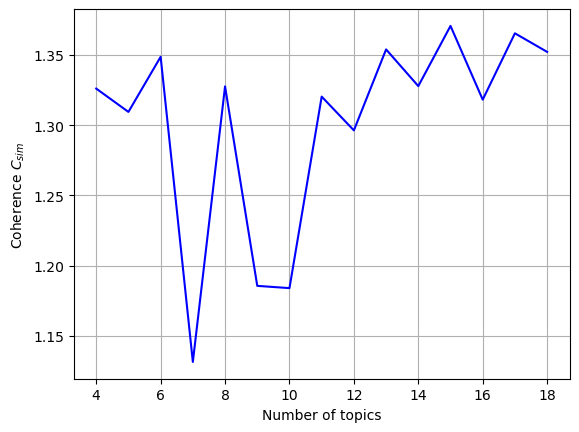

In [9]:
# Coherence Score per number of topics
topic_number = range(4, 19, 1)
plt.plot(topic_number, coherence_sim, 'b', label=r'$C_{sim}$')
plt.xlabel('Number of topics')
plt.ylabel(r'Coherence $C_{sim}$')
plt.grid()

The highest coherence score is at 15 topics. Which means that it is the number of topics for which the themes within a topic are most similar and the topics between them are most different. Thus, for the rest of the analysis we will classify our movies between those 15 topics

### Part 3.2: What topics did we recover?
Let's see first what's the word distribution for each topic is:

In [10]:
# Load model
lda_model = LdaModel.load("src/models/lda_model15.model")

# Display 8 most relevant word per topic
for topic_id, topic_words in lda_model.print_topics(num_words=8):
    print(f"Topic {topic_id}: {topic_words}")

Topic 0: 0.006*"police" + 0.006*"car" + 0.005*"murder" + 0.004*"killer" + 0.004*"shoot" + 0.004*"run" + 0.003*"reveal" + 0.003*"escape"
Topic 1: 0.005*"murder" + 0.005*"say" + 0.005*"woman" + 0.004*"ask" + 0.003*"case" + 0.003*"look" + 0.003*"work" + 0.003*"police"
Topic 2: 0.012*"say" + 0.008*"ask" + 0.008*"get" + 0.008*"room" + 0.007*"house" + 0.007*"look" + 0.007*"door" + 0.006*"run"
Topic 3: 0.004*"Beast" + 0.004*"barricade" + 0.004*"life" + 0.003*"escape" + 0.003*"Marius" + 0.003*"house" + 0.003*"daughter" + 0.003*"order"
Topic 4: 0.005*"game" + 0.005*"say" + 0.004*"team" + 0.004*"ask" + 0.004*"Lord_Blackwood" + 0.004*"Lord" + 0.003*"run" + 0.003*"room"
Topic 5: 0.007*"Macbeth" + 0.006*"king" + 0.005*"son" + 0.005*"King" + 0.004*"army" + 0.004*"prophecy" + 0.004*"castle" + 0.004*"order"
Topic 6: 0.009*"car" + 0.009*"say" + 0.007*"ask" + 0.007*"get" + 0.006*"police" + 0.006*"money" + 0.006*"gun" + 0.005*"shoot"
Topic 7: 0.020*"Sir" + 0.004*"musketeer" + 0.003*"ask" + 0.003*"uncle" 

From this list of words we observe that the preprocessing isn't perfect because some character names still remain as they were not recognize by the spacy analyzer. However we can still easily dicerner some topics. For example the topic 0 seems to describe crime movies, with keywords like police, murder, shoot and car. We asked the NLP AI Chat-GPT ([source](https://chatgpt.com)) to name each topic depending on its words distribution. Here are the names of each topic:

| Topic | Keywords                    | Theme                                  |
|-------|-----------------------------|----------------------------------------|
| 0     | police, car, murder         | Crime and Pursuit                      |
| 1     | murder, woman, case         | Investigative Drama                    |
| 2     | say, ask, room              | Domestic Suspense                      |
| 3     | Beast, barricade, escape    | Struggle and Sacrifice                 |
| 4     | game, team, treasure        | Adventure and Teamwork                 |
| 5     | Macbeth, king, prophecy     | Shakespearean Power Struggles          |
| 6     | car, police, money          | Urban Crime and Violence               |
| 7     | Sir, musketeer, airship     | Historical and Heroic Tales            |
| 8     | Lincoln, look, life         | Identity and Discovery                 |
| 9     | say, money, love            | Emotional Conflict and Drama           |
| 10    | house, vampire, family      | Supernatural and Gothic                |
| 11    | love, family, school        | Family and Everyday Life               |
| 12    | guard, musketeer, sword     | Adventure and Loyalty                  |
| 13    | say, look, castle           | Drama and Character Interaction        |
| 14    | escape, attack, team        | Action and Strategy                    |


Let's add to the dataframe the distribution of topics for each movie, and the main topic (the one with highest distribution).

In [11]:
LDA_final = pd.read_csv('Data/LDA_df.csv') # Import LDA_df to further modify it

In [12]:
topic_distrib = [sorted(lda_model.get_document_topics(doc), key=lambda x: x[1], reverse=True) for doc in corpus]
LDA_final.insert(loc=len(LDA_final.columns), column='Topics', value=topic_distrib)
topic_dic = {
    0: 'Crime and Pursuit', 1: 'Investigative Drama', 2: 'Domestic Suspense', 3: 'Struggle and Sacrifice',
    4: 'Adventure and Teamwork', 5: 'Shakespearean Power Struggles', 6: 'Urban Crime and Violence',
    7: 'Historical and Heroic Tales', 8: 'Identity and Discovery', 9: 'Emotional Conflict and Drama',
    10: 'Supernatural and Gothic', 11: 'Family and Everyday Life', 12: 'Adventure and Loyalty',
    13: 'Drama and Character Interaction', 14: 'Action and Strategy',
}
LDA_final['Main Topic'] = LDA_final['Topics'].apply(lambda x : topic_dic[x[0][0]])
LDA_final.head(3)

imdb_id                                     Movie name  \
0  tt1733125  Dungeons & Dragons: The Book of Vile Darkness   
1  tt0033045                     The Shop Around the Corner   
2  tt0113862                             Mr. Holland's Opus   

                                       plot_synopsis  \
0  Two thousand years ago, Nhagruul the Foul, a s...   
1  Matuschek's, a gift store in Budapest, is the ...   
2  Glenn Holland, not a morning person by anyone'...   

                                     tags  \
0                                violence   
1                                romantic   
2  inspiring, romantic, stupid, feel-good   

                                        Movie genres  averageRating  \
0                                        ['Fantasy']            4.4   
1  ['Romantic comedy', 'Workplace Comedy', 'Black...            8.0   
2  ['Inspirational Drama', 'Family Film', 'Drama'...            7.3   

                                              Topics                Main Topic  
0  [(10, 0.7467012), (14, 0.1037234), (5, 0.07242...   Supernatural and Gothic  
1  [(11, 0.75163704), (1, 0.11554898), (6, 0.0902...  Family and Everyday Life  
2  [(11, 0.8015677), (9, 0.12116513), (2, 0.06243...  Family and Everyday Life

## 3.4 Topics analysis
What kind of topics did we get? Are there significantly different from each other?

### 3.3.2 Topics interpretation with pyLDAvis

In [13]:
# Common way of showing results from an LDA analysis

# Prepare pyLDAvis visualisation
lda_vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualisation
pyLDAvis.display(lda_vis_data)

The topics are ordered based on the percentage of tokens that were used to create them. By setting the relevance to 1 (λ=1), we can see how much each topic uses this word. Words like "army" appear in most topics. But in order to differentiate each other, the topics also have words specific to them that can be seen when setting the relevance to 0 (λ=0). We can then see that for Topic 7, "MacBeth" is an important word specific to this topic.
While only topics `Adventure and Loyalty`, `Identity and Discovery`, and `Family and Everyday Life` are isolated form the rest all other topics are still very different from each other but this is not evident since the 15 dimensions of the topics are projected to only 2 dimensions.

# Part 4: Are topics linked to genres/labels?
### Networks between topics
We begin with networks, where two topics have an edge if they have a genre in common. This is done starting with a bipartite graph between topics and genres. To link a topic with a genre, we check how often this genre appear for movies with the given topic. If this proportion is larger than a chosen threshold, we link the topic to the genre. 

## Part 4.1.1 : Which Topics Are Associated with Specific Genres?

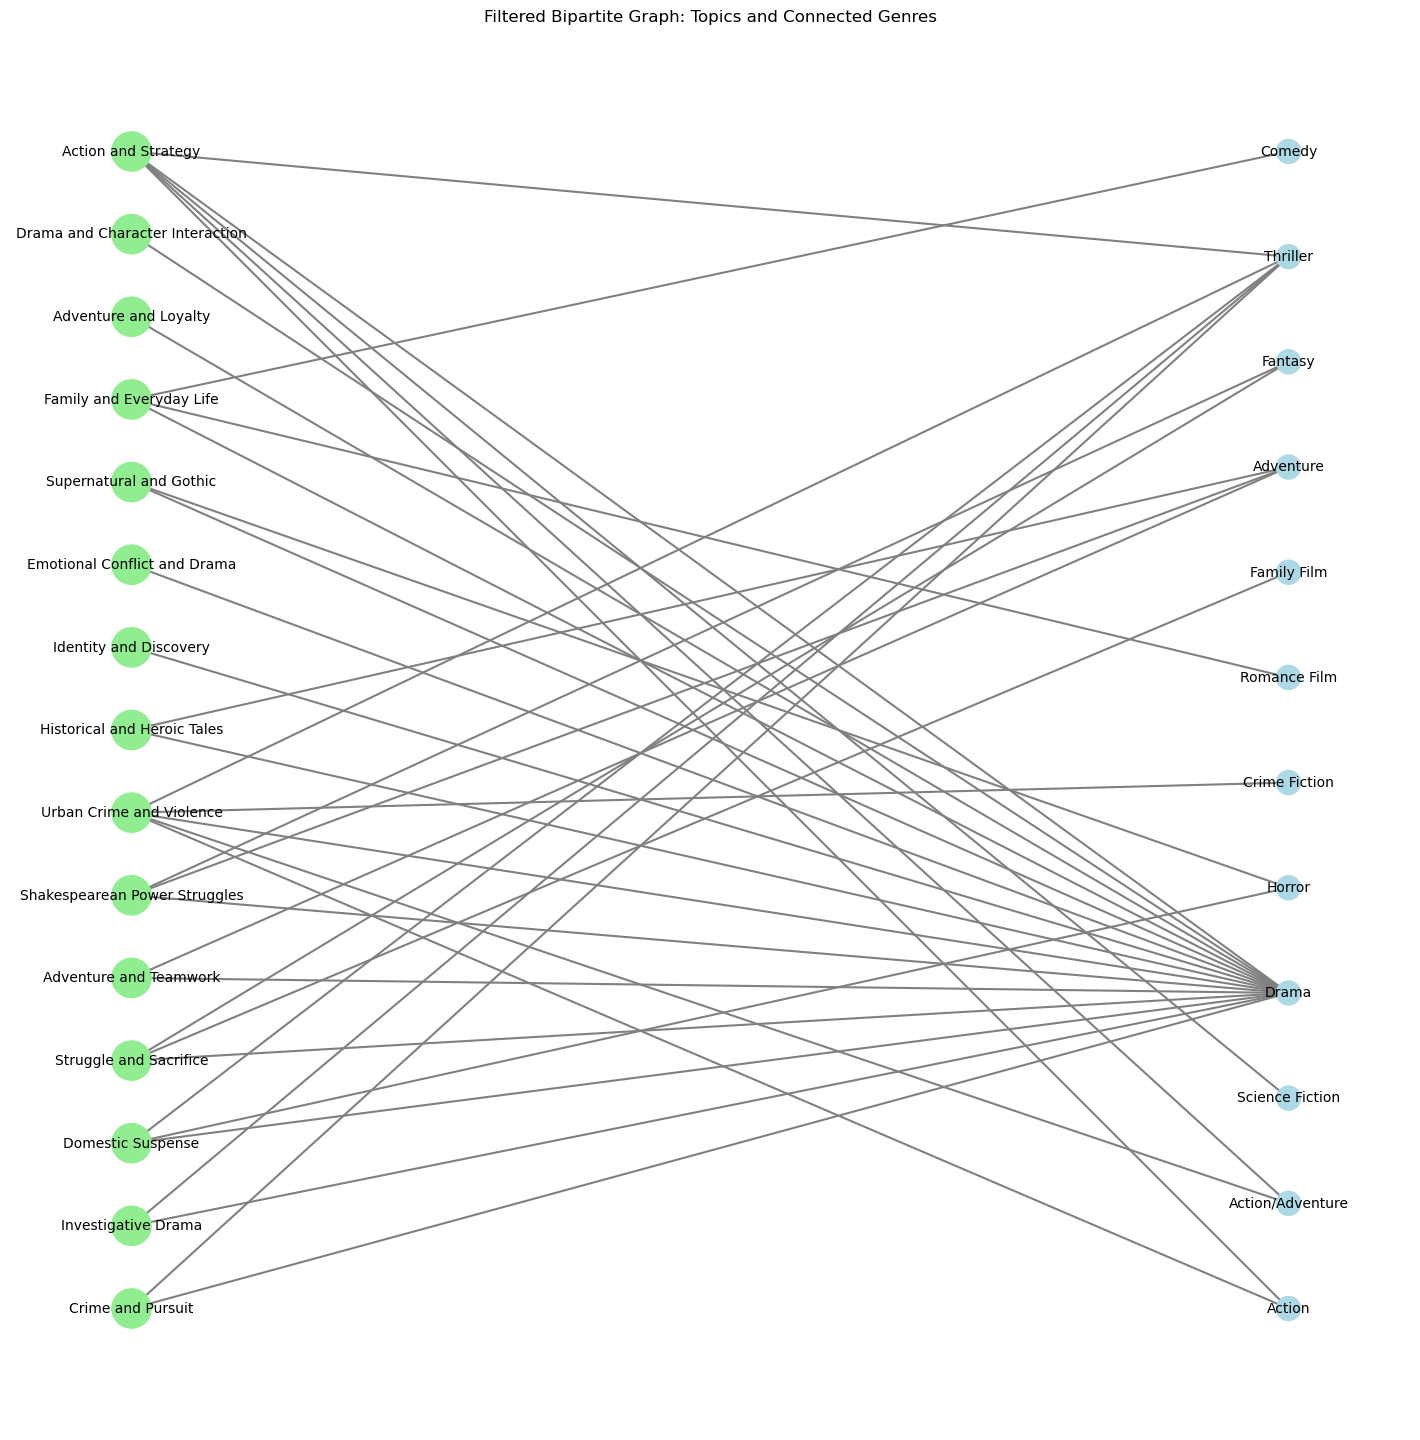

In [14]:
draw_bipartite(LDA_final, topic_dic, threshold=0.29, mode='genres')

We see that most genres and topics do not appear since they are not linked . Among the linked categories, the `Drama` genre stands out, being represented by multiple subtopics. Conversely, some topics serve as aggregates of genres; for instance, `Urban Crime and Violence` can encompass subgenres such as `Thriller`, `Drama`, `Adventure` and `Crime Fiction`.

## Part 4.1.2: How are topics linked together based on genres similarity

To assess how similar topics are we can analyse how many genres connections they share. This is done by projecting the bipartite graph into a new graph where only topics are nodes, and the edges represent how many genres two topics share.

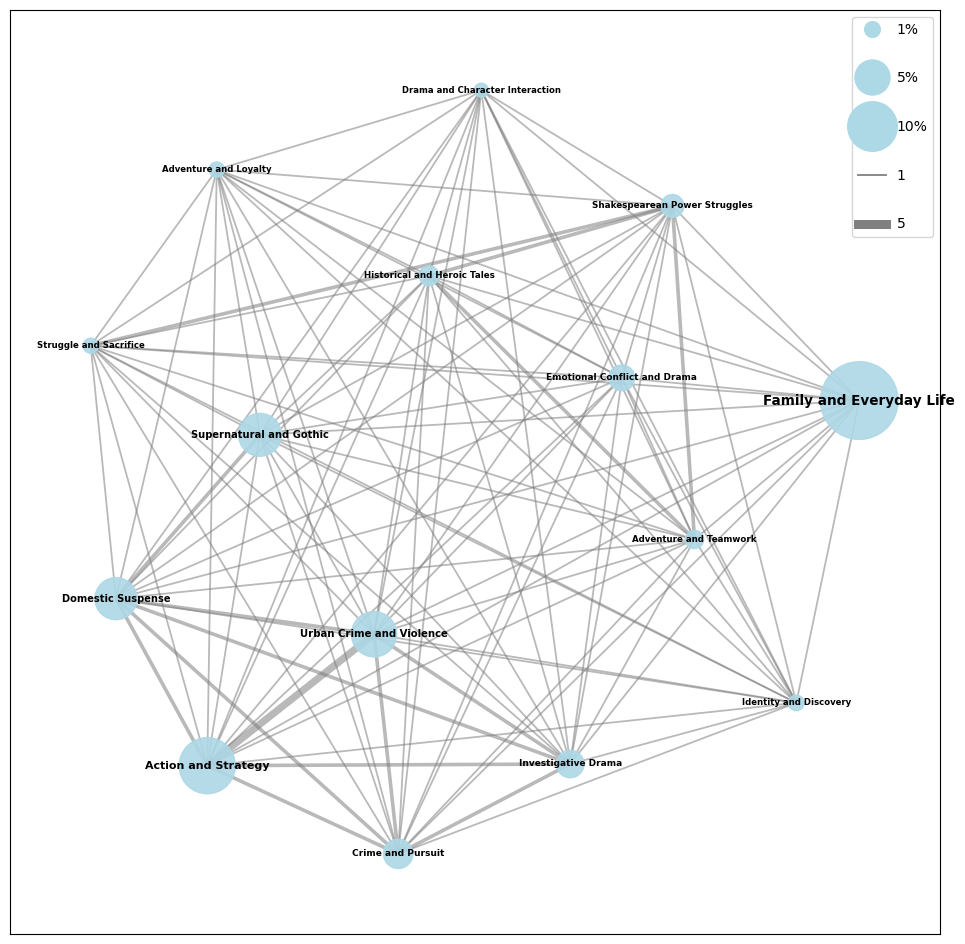

In [15]:
[link_probability_random, link_proportion] = draw_network_genre(LDA_final, topic_dic, threshold=0.29)

We see that the `Family and Everyday Life` is the predominant main topic in our dataset. `Action and Strategy` and `Urban Crime and Violence` have the most genres in common.

### Part 4.1.3: Do topics reflect genres?

To assess if the genres are reflected by genres, we calculate the average probability of a random link between a topic and a genre. By comparing this random probability with the actual proportion of links in our graph, we can evaluate how well our topics are capturing the genres.

In [16]:
print(f'The probability of link if topics were independant of genres would be {round(link_probability_random*100,3)}%.')
print(f'The proportion of link between topics and genres is {round(link_proportion*100,3)}%.')

The probability of link if topics were independant of genres would be 0.004%.
The proportion of link between topics and genres is 1.289%.


We observe that we have way more links than if our genres were randomly distributed. This means that our topics reflects to some extend the genres!

## Part 4.2.1 : Which Topics Are Associated with Specific Tags?
Let's do the same analysis with the labels of the MPST dataset added earlier instead of genres.

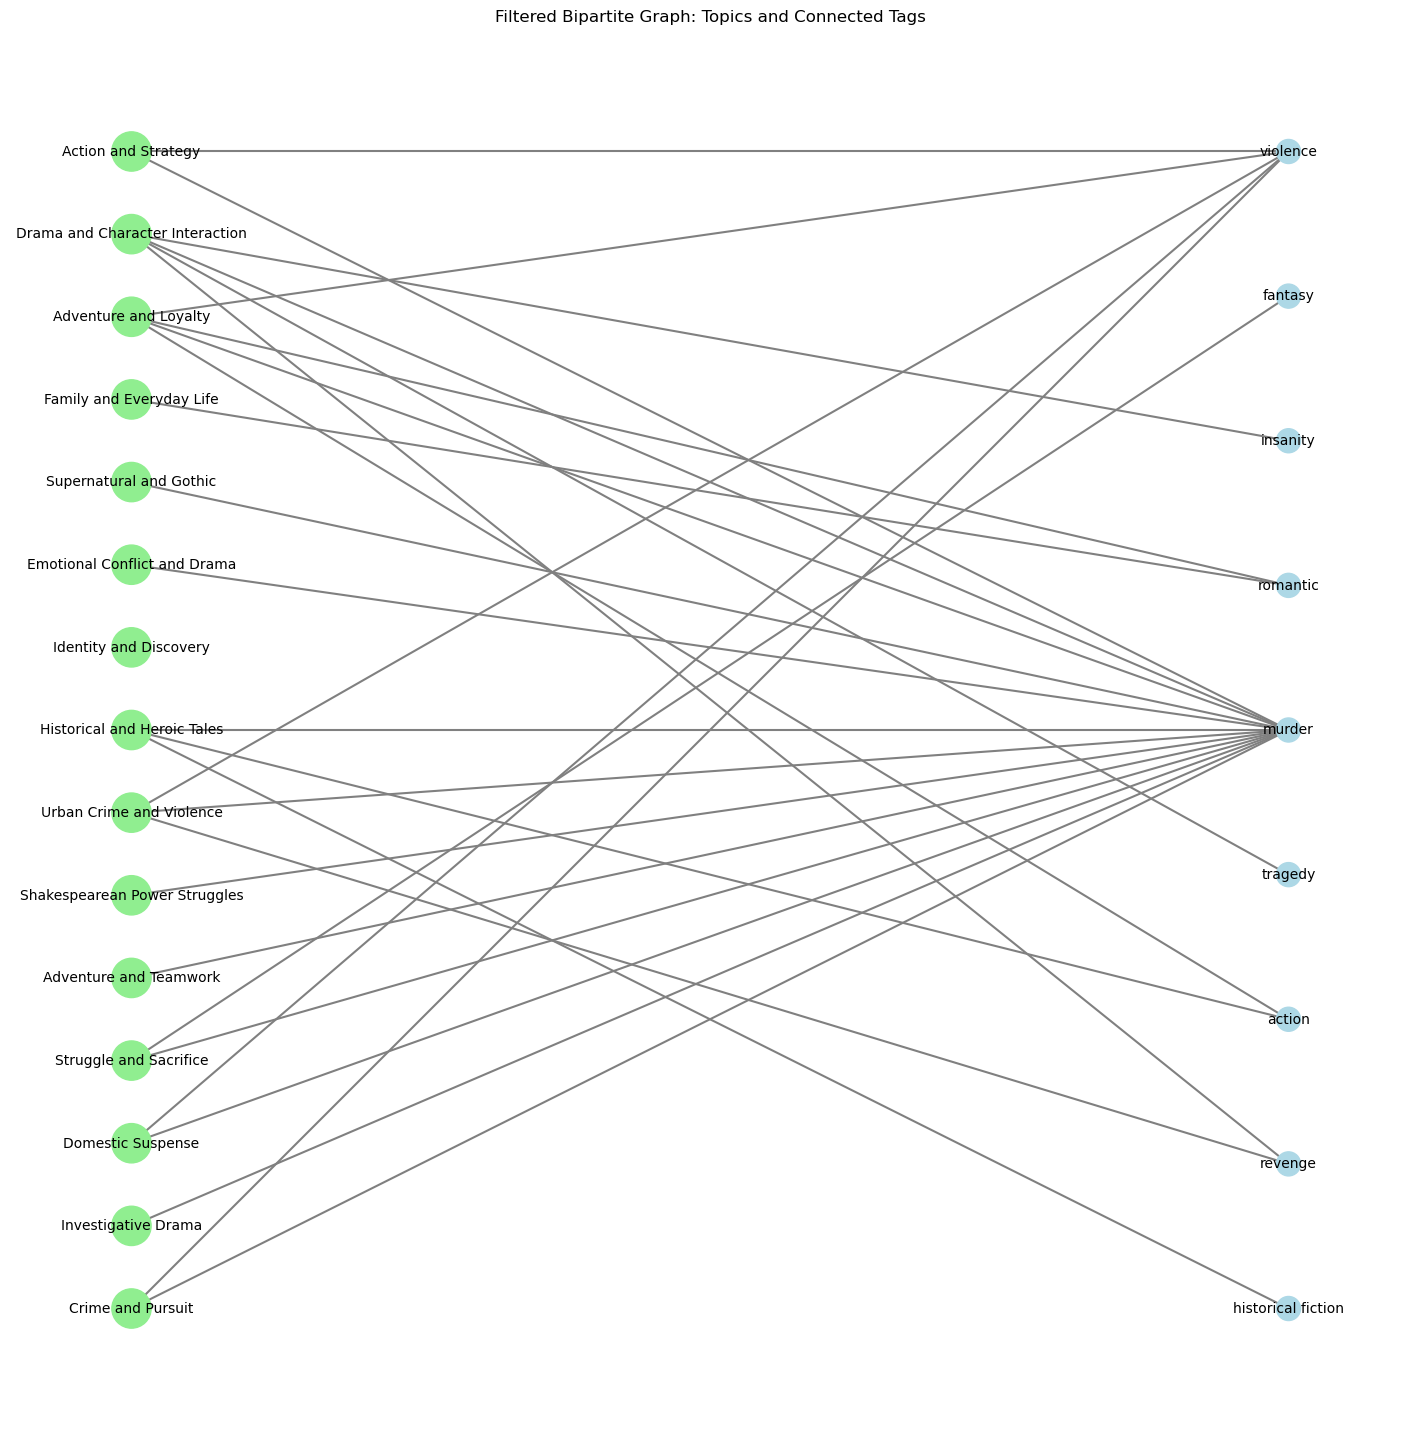

In [17]:
draw_bipartite(LDA_final, topic_dic, threshold=0.29, mode='tags')

We see that most genres and topics do not appear since they are not linked . Among the linked categories, the `Murder` genre stands out, being represented by multiple subtopics. Conversely, some topics serve as aggregates of genres; for instance, `Historical and Heroic Tales` can encompass subgenres such as `Historical Fiction`, `Action`, and `Murder`.

## Part 4.2.2: How are topics linked together based on tags similarity

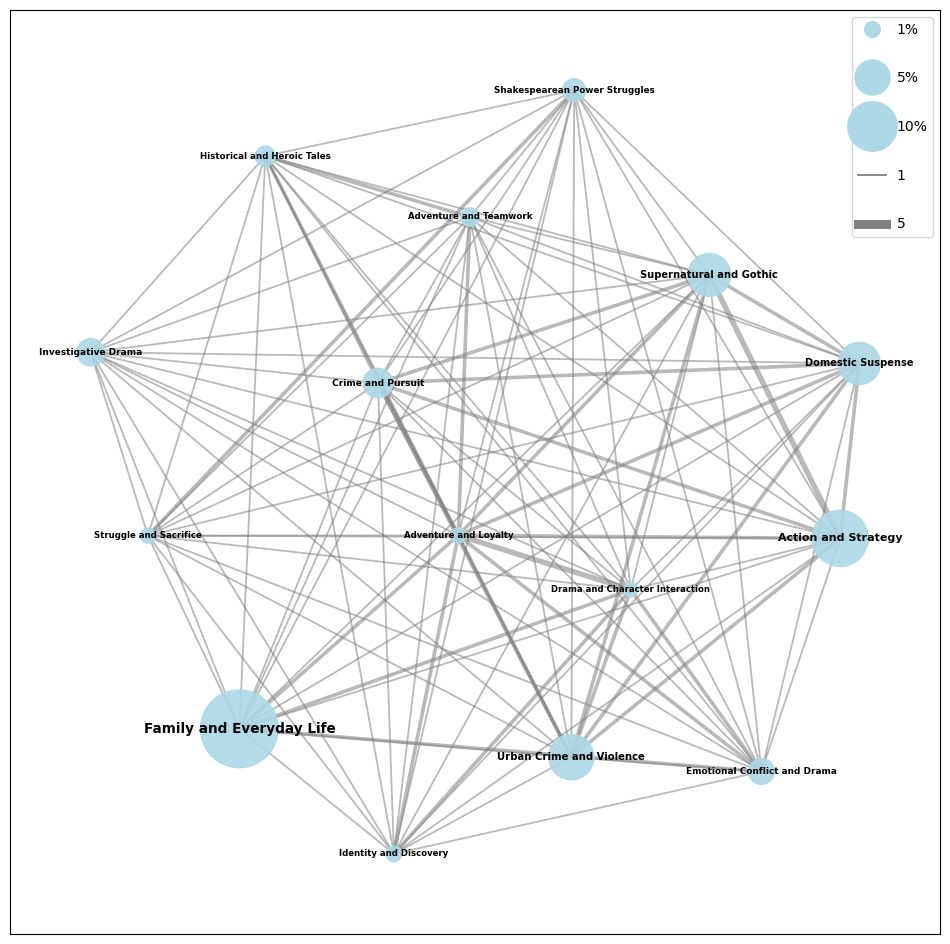

In [18]:
[link_probability_random, link_proportion] = draw_network_tags(LDA_final, topic_dic, threshold=0.25)

We see that smaller topics share the most tags connections such as `Historical and Heroic Tales`, `Crime and Pursuit` and `Adventure and loyalty`.

## Part 4.2.3: Do topics reflect tags?

In [19]:
print(f'The probability of link in a random relation between topics and labels would be {round(link_probability_random*100,3)}%.')
print(f'The proportion of link between topics and labels is {round(link_proportion*100,3)}%.')

The probability of link in a random relation between topics and labels would be 4.29%.
The proportion of link between topics and labels is 4.29%.


The two percentages are surprisingly close. This means labels are statistically random for our topics. We thus can't infer any trends between topics and tags from this network.

# Part 5: Recommendations!!!

Now that we have discovered new information about a movie. Let's put it to use for movie recommendation. Give us a movies you like, you will get a new movie recommendation by picking the most similar movie (closest topics).

In [20]:
# Convert to list
LDA_final['Topics'] = LDA_final['Topics'].apply(format_topics)

# Convert to array
LDA_final['Topics'] = LDA_final['Topics'].apply(np.array)

# Check results
print(LDA_final['Topics'].head().value_counts())

Topics
[0.0, 0.0, 0.0, 0.0, 0.07204169034957886, 0.0724283754825592, 0.0, 0.0, 0.0, 0.0, 0.746701180934906, 0.0, 0.0, 0.0, 0.10372339934110641]                     1
[0.0, 0.1155489832162857, 0.04013890400528908, 0.0, 0.0, 0.0, 0.090211883187294, 0.0, 0.0, 0.0, 0.0, 0.7516370415687561, 0.0, 0.0, 0.0]                      1
[0.0, 0.0, 0.06243693456053734, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12116512656211853, 0.0, 0.8015676736831665, 0.0, 0.013975027948617935, 0.0]                  1
[0.05606048181653023, 0.0506233312189579, 0.0, 0.0, 0.0, 0.0, 0.6062084436416626, 0.0, 0.0, 0.0, 0.0, 0.17218393087387085, 0.0, 0.0, 0.10554042458534241]    1
[0.056074731051921844, 0.05076221004128456, 0.0, 0.0, 0.0, 0.0, 0.6061465740203857, 0.0, 0.0, 0.0, 0.0, 0.172130286693573, 0.0, 0.0, 0.10551361739635468]    1
Name: count, dtype: int64


All topics are well formatted let's now compute the most similar movie with a recommendation algorithm

In [21]:
# Prompt the user for input
movie_name = input("Please enter a movie name: ") # Scarface, The Godfather

print(recommend_similar_movie(movie_name, LDA_final))

Error: This Movie is either mispelled or not in the database.


# Part 6: Similarity Analysis
### Are Topics enough for recommandation ?

We will first start by make the assumption that similar topics have similar ratings. In fact if we do not want to recommend movies based on the highest rating, if you liked a cheesy low-rated christmas movie you might not want to watch the highest Can prized movie next. We will first analyse if this statement is true for genres and then see if similar movies have similar ratings using dimensionality reduction analysis.

## Part 6.1: Are ratings similar accross genres?
First we will start by analyzing how the ratings change across genres. 

In [21]:
features_df = pd.read_csv('Data/features_df.csv')

In [23]:

# Plot the ratings distribution across top genres
plot_ratings_dropdown(features_df, genre_column='Movie genres', rating_column='averageRating', top_n=30, output_html="ratings_dropdown.html")

From the ratings distribution across genres, we see that they all tend to follow a binomial distribution. Some have their means higher than others. For example "Fantasy" movie ratings has its mean around 7 while "Cult" movies have lower ratings with a mean around 6. 

In [26]:
top_20_genres = genres_counts.head(20).index.tolist()

plot_genre_boxplot(features_df, genre_column='Movie genres', rating_column='averageRating', top_genres=top_20_genres)

The boxplot helps visualizes the IMDb ratings distribution across different movie genres. Each box represents the range of ratings for a specific genre, with the thick line in the middle indicating the median rating. Genres like "Drama," "Thriller," and "Crime Thriller" show a broad spread of ratings, with outliers both on the high and low ends. "Romantic Drama" and "Musical" tend to have slightly higher medians compared to other genres, indicating consistent audience appreciation. On the other hand, "Horror" exhibits the most variability, with a significant number of low-rated movies pulling the average down. Overall, most genres show ratings concentrated between 6 and 8, suggesting that most movies within these categories are moderately well-received by audiences.

## Part 6.2: Are ratings similar across movies with similar topics?
To investigate this, we apply PCA for dimensionality reduction, bringing similar topics closer together in the reduced space. Next, we analyze whether movies with similar topics have comparable ratings by visualizing their ratings.

### Part 6.2.1 PCA to group topics together

In [24]:
# Extract topic probabilities
topic_probabilities = np.array(LDA_final['Topics'].tolist())

# Perform PCA to reduce from 15 to 3 dimensions only
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(topic_probabilities)

# Add reduced dimensions to the dataframe
LDA_final['PC1'] = reduced_data[:, 0]
LDA_final['PC2'] = reduced_data[:, 1]
LDA_final['PC3'] = reduced_data[:, 2]

# Create an interactive 3D scatter plot showing the movies grouped by topics
plot_3d_pca(LDA_final, 'PC1', 'PC2', 'PC3', 'Main Topic', "Interactive 3D PCA of Movies' Main Topic")

Here the 15 dimensions of the topics were reduced to 3 using PCA. This allows to visualize the clustering of movies based on their topics, where in fact more similar movies appear close together in this 3d space. 

### Part 6.2.2 Do similar movies with similar topics share similar ratings?

In [25]:
# Create an interactive 3D scatter plot showing the movies grouped by topics but displaying their average rating
create_3d_scatter_with_ratings(LDA_final, 'PC1', 'PC2', 'PC3', 'averageRating', "Interactive 3D PCA of Movies' Ratings")

The ratings appear like salt & pepper. In fact it is verified that we have our similarity measure is not up to point with movie plot only analysis. Movies that are considered as very similar by LDA, appear to have very different ratings. 

# Part 7: Additional features Analysis
## Can others features explain the ratings?

In this part, we want to determine wheter the ratings can be explained by other features. To do so, we trained three different models for linear regression. To see which one would be the better. The first model will use only numerical features, the second will use only categorical features, and the third will combine both numerical and categorical features. This approach allowed us to determine which model performs best and identify which features have the most significant impact on the average ratings. This analysis has been performed in `model_training.ipynb`.

In this notebook we found that the top predictors for each features where the follwing: 

| **Feature** | **Top Positive Features** | **Top Negative Features** |
|---------------------------|-------------------------------------------------------|-------------------------------------------------------|
| **Tags** | non: 0.9889<br>historical: 0.9232<br>atmospheric: 0.7971 | stupid: -0.6546<br>pornographic: -0.5529<br>fiction: -0.4647 |
| **Movie genres** | period: 11.0128<br>films: 3.6277<br>supermarionation: 2.7029 | filipino: -14.0698<br>piece: -10.7665<br>hardcore: -6.2392 |
| **Movie languages** | language: 10.6496<br>serbo: 2.1239<br>taiwanese: 1.5688 | english: -10.1485<br>bosnian: -4.0629<br>french: -2.9289 |
| **Movie countries** | philippines: 13.2904<br>and: 2.7170<br>montenegro: 1.9247 | lithuania: -2.7849<br>aruba: -1.7089<br>bulgaria: -1.6233 |
| **Numerical Importance** | Movie runtime: 0.1374<br>numVotes: 0.1897<br>IMDB Box-office: 0.0052 | Not applicable |


# What can be uncovered from each categories?

- **_Tags: The Critics' Favorite Words_**
People love movies with tags like non, historical, and atmospheric. These are the movies that feel deep, immersive, or give that epic historical vibe. On the other hand, movies tagged as stupid, pornographic, or fiction are a hard no. If a movie feels unintelligent, offensive, or just plain generic, it’s doomed.


- **_Genres: The Plot Thickens_**
Movies in genres like period, films, and supermarionation get high ratings. Audiences love historical dramas or unique, creative storytelling styles. While, genres like filipino, piece, and hardcore struggle to connect. These could be too niche or just missing the mark with mainstream viewers.


- **_Languages: Tongues That Talk to Audiences_**
Films in languages like language, serbo, and taiwanese are big hits. Audiences seem to enjoy the cultural freshness and unique perspectives these movies bring. Surprisingly, movies in English, Bosnian, and French don’t fare as well. For English, it might be because they composed a large number of movies in our dataset, making it harder to stand out. 


- **_Countries: Where It’s Made Matters_**
Movies from the Philippines, And, and Montenegro are getting noticed for all the right reasons. These countries might be delivering fresh, exciting stories that capture audience attention. Nevertheless, films from Lithuania, Aruba, and Bulgaria tend to flop. These could face challenges with global appeal or just lack visibility. But notice that we have few movies that comes from those countries so this is probably a bit biased. 


- **_Numbers: Crunching the Data_**
Two things stand out runtime and number of votes. Longer movies often mean deeper storytelling, and more votes mean more engagement, which boosts ratings. Surprisingly, box office earnings don’t matter much when it comes to ratings. Just because a movie makes money doesn’t mean people think it’s good.


## The Big Picture: What Makes a Movie Shine?
- **Be Unique:** Audiences love creativity, whether it’s a historical epic or an unusual niche genre. Stand out, and you’ll win hearts.
- **Don’t Be Lazy:** Movies that feel offensive, lazy, or just plain bad sink quickly.
- **Get People Talking:** Engagement is everything. The more people watch and vote, the better your movie’s chances of succeeding.


# Final Part : Conclusion 